# Multinomial Logistic Regression and Cross Validation

Estulate the probability that a given wine comes from a given _cultivar_.

In [334]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from pylab import rcParams
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold


In [208]:
### Import dataset

wine = pd.read_csv('strongdrink.txt', sep=",")
#wine

### A: Multinomial Logistic Regression

Nb: categorical data because 3 categories

The logistic regression model is a binary dependent variable classifier that constraints its predicted values to be strictly between 0 and 1. This is done by using a sigmoid function :

$f(x) = g(x) / (1 + g(x))$

In the case of the Logistic function : 
$g(B) = e^{X*B} = e^{B0 + B1*x1 + B2*x2 + B3*x3 .... + Bp*xp}$

How to estimate the best theta = {B0, B1, B2, ..., Bp) ?

#### Nonlinear Least Squares Estimation

$\epsilon_i = y_i - z_i$
$\theta$ st $min_\theta \sum(e_i)^2$

$z_i = Pr(y_i = 1 | X_i, \theta)$


#### Maximum Likelihood Estimation

MLH because it has the most robust statistical properties.

$\theta_{mle} = \theta : max_\theta ln(L(y_i, Xi|\theta)$


In [165]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

In [183]:
### Divide the data between X and Y
X = wine[["alco", "malic", "tot_phen", "color_int"]].values
y = wine["cultivar"].values

### Add a constant to the X
#num_obs = X.shape[0]
#const_vec = np.ones(num_obs).reshape((num_obs, 1))
#XplusConst = np.hstack((const_vec, X))

### Divide the data between test and train
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25,
       random_state=10)

#print(X_train.shape)
#print(y_train.shape)


### Run the MLHE of out multiple logistic regression classifier model.
LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
#LogReg = LogisticRegression()

LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

print("Estimated coefficiens and intercepts for j=1 ", LogReg.intercept_[0], LogReg.coef_[0,:])
print("Estimated coefficiens and intercepts for j=2 ", LogReg.intercept_[1], LogReg.coef_[1,:])

### Report the error rates (1 - precision)
print(classification_report(y_test, y_pred))


### Manually MSE
MSE_raw = ((y_test - y_pred) ** 2)
for i in range(MSE_raw.shape[0]):
    MSE_raw[i] = min(MSE_raw[i], 1)
MSE_y = MSE_raw.mean()
MSE_y1 = MSE_raw[y_pred==1].mean()
MSE_y2 = MSE_raw[y_pred==2].mean()
MSE_y3 = MSE_raw[y_pred==3].mean()

print("Computed MSE on average is ", MSE_y,
     "\n Computed MSE for y1 is ", MSE_y1,
     "\n Computed MSE for y2 is ", MSE_y2,
     "\n Computed MSE for y3 is ", MSE_y3)

Estimated coefficiens and intercepts for j=1  -20.292802602916396 [ 1.25230292 -0.2049683   1.45813599  0.40918121]
Estimated coefficiens and intercepts for j=2  20.920605961450406 [-1.05123233 -0.44005868  0.55536801 -1.71913401]
              precision    recall  f1-score   support

           1       0.71      1.00      0.83        12
           2       1.00      0.75      0.86        24
           3       0.78      0.88      0.82         8

    accuracy                           0.84        44
   macro avg       0.83      0.88      0.84        44
weighted avg       0.88      0.84      0.84        44

Computed MSE on average is  0.1590909090909091 
 Computed MSE for y1 is  0.29411764705882354 
 Computed MSE for y2 is  0.0 
 Computed MSE for y3 is  0.2222222222222222


The categories that are best predicted by the model are 2 > 1 > 3. This corresponds to the categories with the most observations.

In [177]:
print(wine[wine["cultivar"]==1].shape[0])
print(wine[wine["cultivar"]==2].shape[0])
print(wine[wine["cultivar"]==3].shape[0])

59
71
46


### B. Leave-one-out cross validation (LOOCV)

In [193]:
# Define loo as a leave-one-out object, then split it into N different partitions

N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_vec = np.zeros(N_loo)
MSE_y1 = np.zeros(N_loo)
MSE_y2 = np.zeros(N_loo)
MSE_y3 = np.zeros(N_loo)

y_test_total = np.zeros(N_loo)
y_pred_total= np.zeros(N_loo)

In [194]:
# Loop
for train_index, test_index in loo.split(X):
    # Split x and y between test and train
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #y_test_total[train_index] = y_test
    
    # Run the logit on the training set MULTINOMIAL
    LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    LogReg.fit(X_train, y_train)
    # Predict the train y
    y_pred = LogReg.predict(X_test)
    MSE_raw = (y_pred - y_test) ** 2
    y_pred_total[test_index] = y_pred
    for i in range(MSE_raw.shape[0]):
        MSE_raw[i] = min(1, MSE_raw[i])
    # Get the error for each category
    MSE_vec[test_index] = MSE_raw
    #MSE_y1[test_index] = MSE_raw[y_pred==1]
    #MSE_y2[test_index] = MSE_raw[y_pred==2]
    #MSE_y3[test_index] = MSE_raw[y_pred==3]

    #print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

test estimate MSE loocv= 0.07954545454545454 , test estimate MSE standard err= 0.2705882022679695


In [195]:
MSE_loo_1 = MSE_vec[y_pred_total==1].mean()
MSE_loo_2 = MSE_vec[y_pred_total==2].mean()
MSE_loo_3 = MSE_vec[y_pred_total==3].mean()


print("LOOCV estimate for the test MSE as the average MSE is ", MSE_vec.mean())

print("LOOCV estimate for the test MSE for y=1 is ", MSE_loo_1)

print("LOOCV estimate for the test MSE for y=2 is ", MSE_loo_2)

print("LOOCV estimate for the test MSE for y=3 is ", MSE_loo_3)




LOOCV estimate for the test MSE as the average MSE is  0.07954545454545454
LOOCV estimate for the test MSE for y=1 is  0.09836065573770492
LOOCV estimate for the test MSE for y=2 is  0.08571428571428572
LOOCV estimate for the test MSE for y=3 is  0.044444444444444446


### K-Fold cross validation

In [196]:
from sklearn.model_selection import KFold
k=4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(X)
y_test_total = np.zeros(k)
MSE_vec_kf = np.zeros(k)
MSE_test_y1 = np.zeros(k)
MSE_test_y2 = np.zeros(k)
MSE_test_y3 = np.zeros(k)


k_ind = int(0)
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    # print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    #print(y_pred)
    error_raw = (y_test - y_pred) ** 2
    for i in range(error_raw.shape[0]):
        error_raw[i] = min(error_raw[i], 1)
    error_raw_y1 = error_raw[y_pred==1]
    error_raw_y2 = error_raw[y_pred==2]
    error_raw_y3 = error_raw[y_pred==3]

    MSE_vec_kf[k_ind] = error_raw.mean()
    MSE_test_y1[k_ind] = error_raw_y1.mean()
    MSE_test_y2[k_ind] = error_raw_y2.mean()
    MSE_test_y3[k_ind] = error_raw_y3.mean()

# print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
MSE_kf1 = MSE_test_y1.mean()
MSE_kf2 = MSE_test_y2.mean()
MSE_kf3 = MSE_test_y3.mean()

print('test estimate MSE k-fold=', MSE_kf,
      '\n test estimate MSE standard err=', MSE_kf_std,
     '\n test estimate MSE k-fold for y1 =', MSE_kf1,
     '\n test estimate MSE k-fold for y2 =', MSE_kf2,
     '\n test estimate MSE k-fold for y3 =', MSE_kf3)

test estimate MSE k-fold= 0.09090909090909091 
 test estimate MSE standard err= 0.04821182598999188 
 test estimate MSE k-fold for y1 = 0.11856617647058823 
 test estimate MSE k-fold for y2 = 0.09375 
 test estimate MSE k-fold for y3 = 0.05555555555555555


# Decision Trees

In [254]:
### Import dataset
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
biden = pd.read_csv('biden.csv', sep=",")
from sklearn.metrics import mean_squared_error


In [242]:
# Split between training and test
### Divide the data between test and train
biden = biden.dropna()
X = biden['biden'].values
y = biden[["female", "age", "dem", "rep", "educ"]].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3,
    random_state=25)


print(biden.info())
print(X)
print(y)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1807 entries, 0 to 1806
Data columns (total 6 columns):
biden     1807 non-null int64
female    1807 non-null int64
age       1807 non-null int64
educ      1807 non-null int64
dem       1807 non-null int64
rep       1807 non-null int64
dtypes: int64(6)
memory usage: 98.8 KB
None
[90 70 60 ... 70 60 15]
[[ 0 19  1  0 12]
 [ 1 51  1  0 14]
 [ 0 27  0  0 14]
 ...
 [ 1 60  1  0 12]
 [ 1 91  1  0  8]
 [ 1 34  0  0 16]]


In [245]:
### Use recursive binary splitting to fit a decision tree to the training data
# biden = response variable
# other variables = predictores

max_depth  = 3
min_samples_leaf=5


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4,
                                                    random_state=25)
hit_tree2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=4)
hit_tree2.fit(X_train.reshape(-1,1), y_train)


### Need to split between training and test sets!!



DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

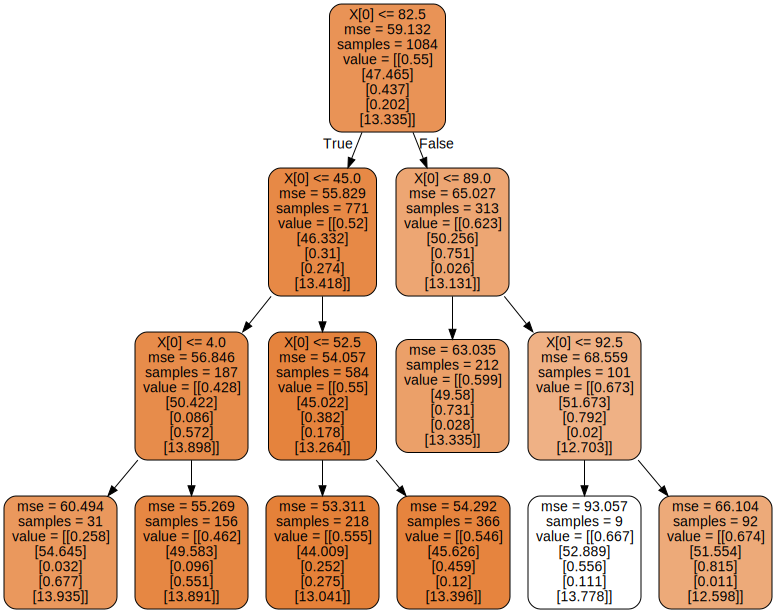

In [246]:
hit_tree_viz = export_graphviz(
    hit_tree2,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz)
graph.render('hit_tree_viz')
graph

In [256]:
y_pred = hit_tree2.predict(X_test.reshape(-1,1))
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 57.10089592812896


### b. Randomizes search CV with optimally tuned hyperparameters from part a's decision tree.

Takes random permutations of the hyperparameters and chooses the permutation that has the best fit.

In [264]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# specify parameters and distributions to sample from
param_dist1 = {'max_depth': [3, 10],
             'min_samples_split': sp_randint(2, 20),
             'min_samples_leaf': sp_randint(2, 20)}
hittree3 = DecisionTreeRegressor()

# Run randomized hyperparameter search
random_search1 = \
    RandomizedSearchCV(hittree3, param_distributions=param_dist1,
                       n_iter=500, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

random_search1.fit(X.reshape(-1,1), y)
print('RandBestEstimator1=', random_search1.best_estimator_)
print('RandBestParams1=', random_search1.best_params_)
print('RandBestScore1=', -random_search1.best_score_)

RandBestEstimator1= DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=16,
                      min_samples_split=9, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
RandBestParams1= {'max_depth': 10, 'min_samples_leaf': 16, 'min_samples_split': 9}
RandBestScore1= 59.930284075444774


### c. Tune the parameters of a RF regression model

In [278]:
from sklearn.ensemble import RandomForestRegressor


### Simple Random Forest

B4 =100
m4 = 1
hit_tree4 = RandomForestRegressor(n_estimators=B4, max_features=m4, bootstrap=True,
                                  n_jobs=-1, oob_score=True, random_state=25)


hit_tree4.fit(X.reshape(-1,1), y)

print('OOB score=', hit_tree4.score(X.reshape(-1,1), y))
y_pred4 = hit_tree4.oob_prediction_
MSE4 = mean_squared_error(y, y_pred4)
print('MSE=', MSE4)

OOB score= 0.026379990485624775
MSE= 58.126276189440375


/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [279]:
### Random Forest + Bootstrapping

max_samples = 100
MSE_vec4 = np.zeros(max_samples)
for ind in range(1, max_samples + 1):
    hit_tree4_loop = RandomForestRegressor(n_estimators=ind, 
                                           max_features='sqrt',
                                           bootstrap=True, 
                                           oob_score=True,
                                           random_state=15)
    hit_tree4_loop.fit(X.reshape(-1,1), y)
    y_pred4_loop = hit_tree4_loop.oob_prediction_
    MSE_vec4[ind - 1] = mean_squared_error(y, y_pred4_loop)
    # print('MSE=', MSE_vec[ind - 1])

print('Min. rnd MSE=', MSE_vec4.min(), ', Min. rnd B=', np.argwhere(MSE_vec4 == MSE_vec4.min())[0, 0] - 1)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

Min. rnd MSE= 58.06362147518628 , Min. rnd B= 79


In [281]:
### Simple Random Forest + Tunning parameters

param_dist2 = {'n_estimators': [10, 200],
               "max_depth": [3, 10],
             "min_samples_split": sp_randint(2, 20),
             "min_samples_leaf": sp_randint(2, 20),
             "max_features": sp_randint(1, 5)}


hit_tree4_loop = RandomForestRegressor()


# Run randomized hyperparameter search
random_search2 = \
    RandomizedSearchCV(hit_tree4_loop, param_distributions=param_dist1,
                       n_iter=500, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

random_search2.fit(X.reshape(-1,1), y)
print('RandBestEstimator1=', random_search2.best_estimator_)
print('RandBestParams1=', random_search2.best_params_)
print('RandBestScore1=', -random_search2.best_score_)



RandBestEstimator1= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RandBestParams1= {'max_depth': 3, 'min_samples_leaf': 14, 'min_samples_split': 9}
RandBestScore1= 59.616201303139434


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# 3. Classifier "horse" race

In [326]:
auto = pd.read_csv('auto.csv', sep=",", header=0)
auto['horsepower'] = auto['horsepower'].apply(pd.to_numeric, downcast='float', errors='coerce')
auto.dropna(inplace=True)

auto["mpg_high"] = (auto["mpg"] >= auto["mpg"].median())*1.
auto["orgn1"] = (auto["origin"]==1)*1.
auto["orgn2"] = (auto["origin"]==2)*1.


In [328]:
# What are the factors that make miles per gallon high or low
auto["mpg_high"] = (auto["mpg"] >= auto["mpg"].median())*1.
y_auto = auto["mpg_high"].values
X = auto[["cylinders", "displacement", "horsepower", 
          "weight", "acceleration", "year", "orgn1", "orgn2"]].values

# Add a constant
num_obs = X.shape[0]
const_vec = np.ones(num_obs).reshape((num_obs, 1))
XplusConst_auto = np.hstack((const_vec, X))

### A. Fit a logistic model of mpg_high

In [329]:
from sklearn.model_selection import KFold
k=4
kf = KFold(n_splits=k, shuffle=True, random_state=25)
kf.get_n_splits(XplusConst_auto)
y_test_total = np.zeros(k)
MSE_vec_kf = np.zeros(k)


k_ind = int(0)
for train_index, test_index in kf.split(XplusConst_auto):
    # print("TRAIN:", train_index, "TEST:", test_index)
    # print('k index=', k_ind)
    X_train, X_test = XplusConst_auto[train_index], XplusConst_auto[test_index]
    y_train, y_test = y_auto[train_index], y_auto[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    #print(y_pred)
    error_raw = (y_test - y_pred) ** 2

    MSE_vec_kf[k_ind] = error_raw.mean()

# print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()

print('test estimate MSE k-fold=', MSE_kf,
      '\n test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.09948979591836735 
 test estimate MSE standard err= 0.027356646160111246


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### B. RandomForest

In [332]:
### Simple Random Forest + Tunning parameters

param_dist2 = {'n_estimators': [10, 200],
               "max_depth": [3, 8],
               "min_samples_split": sp_randint(2, 20),
               "min_samples_leaf": sp_randint(2, 20),
               "max_features": sp_randint(1, 8)}


hit_tree4_loop = RandomForestRegressor()


# Run randomized hyperparameter search
random_search2 = \
    RandomizedSearchCV(hit_tree4_loop, param_distributions=param_dist2,
                       n_iter=100, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search2.fit(XplusConst_auto, y_auto)
print('RandBestEstimator1=', random_search2.best_estimator_)
print('RandBestParams1=', random_search2.best_params_)
print('RandBestScore1=', -random_search2.best_score_)



RandBestEstimator1= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=18,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RandBestParams1= {'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 10, 'min_samples_split': 18, 'n_estimators': 10}
RandBestScore1= 0.08958089905000387


### c. support vector machines model with a Gaussian radial basis function kernel. 

Use sklearn.svm.SVC to fit the model.
Optimally tune the hyperparameters in the support vector machines classifier model.

In [345]:
from scipy.stats import uniform as sp_uniform 
from sklearn import svm


### Divide the data between test and train
X_train, X_test, y_train, y_test = \
    train_test_split(XplusConst_auto, y_auto, test_size = 0.25,
       random_state=10)

auto_svc = svm.SVC(kernel='linear', C=2)
auto_svc.fit(X_train,y_train)
print('OOB score=', auto_svc.score(X_test, y_test))
y_pred3 = auto_svc.predict(X_test)
MSE2 = mean_squared_error(y_test, y_pred3)
print('MSE=', MSE2)

OOB score= 0.8979591836734694
MSE= 0.10204081632653061


In [346]:
### CVM + Tunning parameters

param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0),
              'gamma': ['scale', 'auto'],
              'shrinking': [True, False]}


hit_tree4_loop = svm.SVC()


# Run randomized hyperparameter search
random_search2 = \
    RandomizedSearchCV(hit_tree4_loop, param_distributions=param_dist4,
                       n_iter=100, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search2.fit(XplusConst_auto, y_auto)
#print('RandBestEstimator1=', random_search2.best_estimator_)
print('RandBestParams1=', random_search2.best_params_)
print('RandBestScore1=', -random_search2.best_score_)


RandBestParams1= {'C': 0.3377990724342859, 'gamma': 'scale', 'shrinking': False}
RandBestScore1= 0.11734693877551021


The logistic model does better...

# 4. Neural Network Horse race

Test the predictive accuracy of three models on classifying wines into one of three possible cultivars.

In [365]:
wine = pd.read_csv('strongdrink.txt', sep=",")
### Divide the data between X and Y
X = wine[["alco", "malic", "tot_phen", "color_int"]].values
y = wine["cultivar"].values
#wine

cultivar
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: color_int, dtype: object

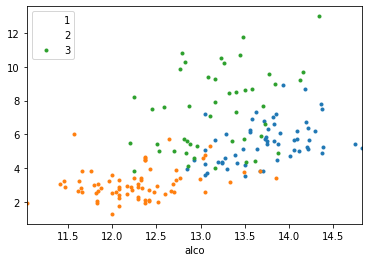

In [360]:
#wine.set_index('alco', inplace=True)
wine.groupby('cultivar')['color_int'].plot(marker='.', 
                                           linestyle='',
                                           legend=True)


In [366]:
# What are the factors that make miles per gallon high or low
y = wine["cultivar"].values
X = wine[["alco", "malic", "tot_phen", 
          "color_int"]].values

# Add a constant
num_obs = X.shape[0]
const_vec = np.ones(num_obs).reshape((num_obs, 1))
XplusConst = np.hstack((const_vec, X))


### Divide the data between test and train
X_train, X_test, y_train, y_test = \
    train_test_split(XplusConst, y, test_size = 0.25,
       random_state=10)

In [367]:
### Fit a multinomial logistic model 

### Run the MLHE of out multiple logistic regression classifier model.
LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
#LogReg = LogisticRegression()

LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

print("Estimated coefficiens and intercepts for j=1 ", LogReg.intercept_[0], LogReg.coef_[0,:])
print("Estimated coefficiens and intercepts for j=2 ", LogReg.intercept_[1], LogReg.coef_[1,:])

### Report the error rates (1 - precision)
print(classification_report(y_test, y_pred))


Estimated coefficiens and intercepts for j=1  -20.292795890400747 [-2.55911111e-07  1.25230318e+00 -2.04969246e-01  1.45813522e+00
  4.09179614e-01]
Estimated coefficiens and intercepts for j=2  20.92046514680566 [ 2.74572997e-06 -1.05122227e+00 -4.40058064e-01  5.55367840e-01
 -1.71913227e+00]
              precision    recall  f1-score   support

           1       0.71      1.00      0.83        12
           2       1.00      0.75      0.86        24
           3       0.78      0.88      0.82         8

    accuracy                           0.84        44
   macro avg       0.83      0.88      0.84        44
weighted avg       0.88      0.84      0.84        44



In [368]:
### Optimally tune the hyperparameters penalty and C in the logistic regression

from scipy.stats import uniform as sp_uniform
param_dist1 = {'penalty': ['11', '12'],
             'C': sp_uniform(0.1, 10.0)}

hit_wine_SVC = svm.SVC()

# Run randomized hyperparameter search
random_search2 = \
    RandomizedSearchCV(hit_wine_SVC, param_distributions=param_dist4,
                       n_iter=200, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search2.fit(XplusConst, y)
#print('RandBestEstimator1=', random_search2.best_estimator_)
print('RandBestParams1=', random_search2.best_params_)
print('RandBestScore1=', -random_search2.best_score_)



RandBestParams1= {'C': 2.424917300687881, 'gamma': 'auto', 'shrinking': False}
RandBestScore1= 0.1534090909090909


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [369]:
### Fit a random forest model of cultivar on the same 4 variables as above.
### Optimally tune the parameters
from scipy.stats import randint as sp_randint
param_dist2 = {'n_estimators': [10, 200],
               "max_depth": [2, 4],
               "min_samples_split": sp_randint(2, 20),
               "min_samples_leaf": sp_randint(2, 20),
               "max_features": sp_randint(1, 4)}


hit_wine_RF = RandomForestRegressor()


# Run randomized hyperparameter search
random_search2 = \
    RandomizedSearchCV(hit_wine_RF, param_distributions=param_dist2,
                       n_iter=200, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search2.fit(XplusConst, y)
print('RandBestEstimator1=', random_search2.best_estimator_)
print('RandBestParams1=', random_search2.best_params_)
print('RandBestScore1=', -random_search2.best_score_)



RandBestEstimator1= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=19,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RandBestParams1= {'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 19, 'n_estimators': 10}
RandBestScore1= 0.5628096729280687


In [371]:
### Fit a support vector machines classifier model of cultivar with a Gaussian radial basis
# function kernel

param_dist4 = {'C': sp_uniform(loc=0.1, scale=10.0),
              'gamma': ['scale', 'auto'],
              'shrinking': [True, False]}


hit_wine_SVC = svm.SVC()


# Run randomized hyperparameter search
random_search2 = \
    RandomizedSearchCV(hit_wine_SVC, param_distributions=param_dist4,
                       n_iter=200, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search2.fit(XplusConst, y)
#print('RandBestEstimator1=', random_search2.best_estimator_)
print('RandBestParams1=', random_search2.best_params_)
print('RandBestScore1=', -random_search2.best_score_)


RandBestParams1= {'C': 8.469281639209688, 'gamma': 'scale', 'shrinking': True}
RandBestScore1= 0.1534090909090909


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [373]:
### Fil multiple hidden layer neural network (multiple layer perceptron)
# model of cultiver

import sklearn.neural_network as neural_network

param_dist4 = {'hidden_layer_sizes': sp_randint(1, 100),
               'activation': ['logistic', 'relu'],
               'alpha': sp_uniform(0.1, 10.0)}


hit_wine_MLPC = neural_network.MLPClassifier()


# Run randomized hyperparameter search
random_search2 = \
    RandomizedSearchCV(hit_wine_MLPC, param_distributions=param_dist4,
                       n_iter=200, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search2.fit(XplusConst_auto, y_auto)
#print('RandBestEstimator1=', random_search2.best_estimator_)
print('RandBestParams1=', random_search2.best_params_)
print('RandBestScore1=', -random_search2.best_score_)


RandBestParams1= {'activation': 'logistic', 'alpha': 3.0301188113468682, 'hidden_layer_sizes': 81}
RandBestScore1= 0.09183673469387756


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The best approach is the neural net.
The logistic regression then does better than the machine classifier and SVC. Random forest doesn't do very well.


The neural net is the most flexible and sophisticated approach. 
The RF doesn't do very well because there are not many parameters.